# ele.gan.t facades

This tutorial demonstrates how to build and train a conditional generative adversarial network (cGAN) using the pix2pix python library developed through our end of study project at Le Wagon bootcamp.

**Authors** : Amor Hamza, Chaigneau Colin, Duverger Alexandre, Sadaouni Oumnia

<p align="center">
<br>
  <img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2Ff80adc2b-9f33-4f35-8030-0eacdb2e2a77%2Ftest2.jpg?table=block&id=36acfc6b-6b78-4722-8905-2486c407cfb6&spaceId=b9592099-2b37-4101-aeaa-24da873f1526&width=2000&userId=46c52212-dcdf-44a2-b4b8-796d09177007&cache=v2" />
</p>
<p align="center">
Generated image from the cGan model
  </p>

## Import libraries

In [ ]:
!pip install -q -U pip
!pip install -q git+https://github.com/aduverger/pix2pix

In [ ]:
from pix2pix.data import *
from pix2pix.cgan import *
from pix2pix.models import *
import random
import time
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from ipywidgets import interact
from IPython import display

## Load and prepare the dataset

First download the dataset from Berkeley and save it on this Colab temporary drive. You can also use your own dataset, as long as it meets the following criteria :
- Use 3 folders : train, val, test
- Input and output image must be on the same file, which has a shape of 512x256

In [ ]:
!curl -O http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
!tar -xzf facades.tar.gz

Create tensorflow datasets from the images you just downloaded:


In [ ]:
ds_train, ds_val, ds_test = get_dataset(host='/content/facades')

## Create the models

GANs rely on a generator that learns to generate new images, and a discriminator that learns to distinguish synthetic images from real images.

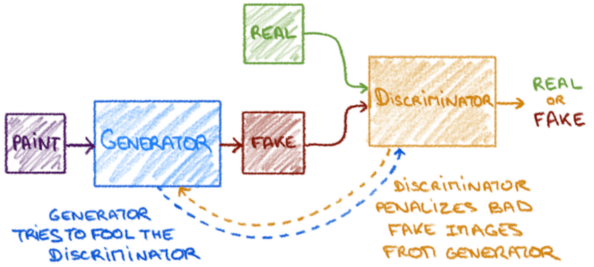

### The Generator

#### Encoder-Decoder

The Encoder-Decoder generator uses tf.keras.layers.Conv2D (downsampling) and tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a image : encoder-decoder.

We use strided convolutions instead of pooling layers, as describe in deep convolutional GAN original paper. All ReLU are leaky, with slope 0.2. Dropout with a rate of 50% are applied to the first 3 layers of the decoder.

Weights are initialized from a Gaussian distribution with mean 0 and standard deviation 0.02.

encoder architecture:
C64-C128-C256-C512-C512-C512-C512-C512

decoder architecture:
CD512-CD512-CD512-C512-C256-C128-C64

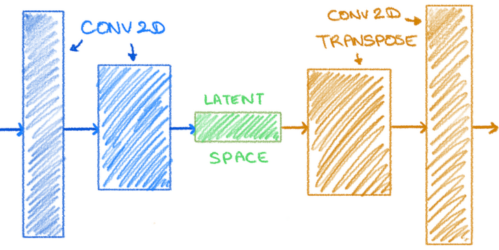

Visualize the encoder model architecture:

In [ ]:
encoder = make_generator_encoder_model()
tf.keras.utils.plot_model(encoder, show_shapes=True, dpi=64)

Visualize the decoder model architecture:

In [ ]:
decoder = make_generator_decoder_model()
tf.keras.utils.plot_model(decoder, show_shapes=True, dpi=64)

Visualize the encoder-decoder model architecture:

In [ ]:
encoder_decoder = make_generator_encoder_decoder_model(encoder, decoder)
tf.keras.utils.plot_model(encoder_decoder, show_shapes=True, dpi=64)

You can try to train a encoder-decoder alone, to see how well it performs at generating realistic building facades from sketches :

In [ ]:
encoder_decoder_alone = CGAN(encoder_decoder, cgan_mode=False)
n_epoch = 200

encoder_decoder_alone.fit(train_ds=ds_train,
                          val_ds=ds_val,
                          epochs=n_epoch,
                          epoch_gen=n_epoch,
                          l1_lambda=1)

#### U-net

If you tried to train the encoder-train, you should have notice that it performs quite badly as a generator.

A U-Net architecture actually performs better as it "remembers" the input images during its forward propagation.

The U-Net architecture is identical to the Encoder-Decoder except with skip connections between each layer i in the encoder and layer n−i in the decoder, where n is the total number of layers. The skip connections concatenate activations from layer i to layer n − i. This changes the number of channels in the decoder:
CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128

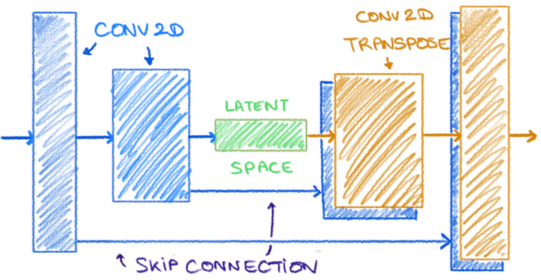

Visualize the U-Net model architecture

In [ ]:
unet = make_generator_unet_model()
tf.keras.utils.plot_model(unet, show_shapes=True, dpi=64)

You can try to train a u-net alone, to see how well it performs at generating realistic building facades from sketches :

In [ ]:
unet_alone = CGAN(unet, cgan_mode=False)
n_epoch = 200

unet_alone.fit(train_ds=ds_train,
               val_ds=ds_val,
               epochs=n_epoch,
               epoch_gen=n_epoch,
               l1_lambda=1)

### The Discriminator

As we noticed from using generators alone to performs our task, they don't do so well..

We therefore need to introduce an additional neural network, called a discriminator, to challenge our generator to perform better.

The discriminator is a CNN-based image classifier : C64-C128-C256-C512-C512-C512

Visualize the discriminator model architecture

In [ ]:
discriminator = make_discriminator_model()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

The research paper introduced the concept of convolutional “PatchGAN” classifier, which only penalizes structure at the scale of image patch. This discriminator tries to classify if each 70x70 patch in an image is real or fake. We run this discriminator convolutionally across the image, averaging all responses to provide the ultimate output of the discriminator.

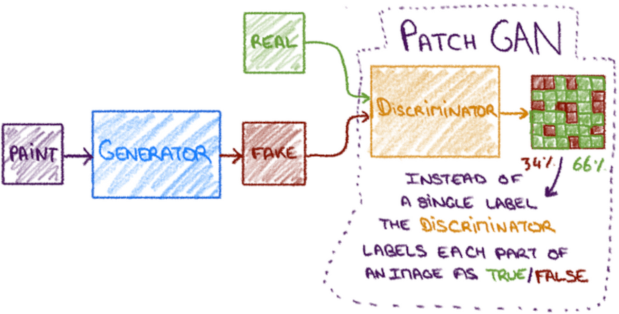

Visualize the Patch-discriminator model architecture

In [ ]:
patch_discriminator = make_patch_discriminator_model()
tf.keras.utils.plot_model(patch_discriminator, show_shapes=True, dpi=64)

## Train the model

Instantiate a cGAN model

In [ ]:
generator = make_generator_unet_model()
#discriminator = make_discriminator_model()
discriminator = make_patch_discriminator_model()
model = CGAN(generator, discriminator)

Little hack to always have the same images displayed during the training process. If you prefer to have random images at each epoch, don't run this cell

In [ ]:
model.random_sample=False
model.paint_train, model.real_train = \
                        load_and_split_image('/content/facades/train/20.jpg')
model.paint_val, model.real_val = \
                        load_and_split_image('/content/facades/val/21.jpg')

Use the cell below if you wan to change the optimizers of the generator and discriminator. It can be usefull if you want to lower their learning rates after you already trained your model for a certain number of epochs. 

**Don't run this cell if you start your training from scratch.**

In [ ]:
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5)
model.compile(gen_optimizer, disc_optimizer)

Then finally, train your model :

In [ ]:
# Use `init` to start over your previous training.
# e.g. : you trained your model for 150 epochs. Then set init=150 so that your model will start training at epoch=150
init = 0
n_epoch = 200
model.fit(train_ds=ds_train, val_ds=ds_val,
          epochs=init+n_epoch, initial_epoch=init,
          epoch_gen=5, epoch_disc=0,
          k=1, l1_lambda=100)

## Test and save your work

### Save and load models

Save model, history and images:

In [ ]:
model_name = 'my_model'
model.generator.save(f'{model_name}/generator'+'.h5', save_format='h5')
model.discriminator.save(f'{model_name}/discriminator'+'.h5', save_format='h5')
hist_file = open(f'{model_name}/history.pkl', 'wb')
pickle.dump(model.history, hist_file)
hist_file.close()

You can load your own model if you want. Here, we provide an already trained model, which can also be used from our website [YesWeGan](https://yeswegan.herokuapp.com/).
Download the [trained model from our drive](https://drive.google.com/file/d/19YAi9xt5s4GbMjb6junyXHbukn6gKGoJ/view?usp=sharing) and put it at the root of this Colab Drive. Then load the model using the cell below:


In [ ]:
new_generator = tf.keras.models.load_model('elegant_facade_trained_model.h5')

### Visualize predictions

In [ ]:
_, _, paint_ds_test, _, _, real_ds_test = get_facades_datasets(host='/content/facades')

In [ ]:
paint_test = np.array([X for batch_X in iter(paint_ds_test) for X in batch_X])
real_test = np.array([Y for batch_Y in iter(real_ds_test) for Y in batch_Y])
fake_test = new_generator(paint_test, training=True)
@interact(index = range(paint_test.shape[0]))
def plot_pred(index):
    fig, axs = plt.subplots(1, 3, figsize=(30,30))
    axs[0].imshow((paint_test[index] * 127.5 + 127.5).astype('uint8'))
    axs[0].axis('off')
    axs[1].imshow((fake_test[index] * 127.5 + 127.5).numpy().astype('uint8'))
    axs[1].axis('off')
    axs[2].imshow((real_test[index] * 127.5 + 127.5).astype('uint8'))
    axs[2].axis('off')
    plt.show()